In [1]:
# enable autoreload
%load_ext autoreload
%autoreload 2
%matplotlib inline
%reload_ext autoreload

import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION']='python'

import scvi
scvi.settings.seed = 0
import scanpy as sc
import anndata as ad
import torch
import numpy as np
import pandas as pd
import json
from datetime import datetime
from scipy.sparse import csr_matrix
torch.set_float32_matmul_precision('medium')
import warnings
warnings.simplefilter("ignore", UserWarning)



Seed set to 0


In [2]:
import pertpy

ryp2 is not installed. Install with pip install rpy2 to run tools with R support.

To use sccoda or tasccoda please install ete3 with pip install ete3

In [3]:
# import from scfair-reproducibility
# from dis2pm_dev.scfair_reproducibility.benchmark_VAE.vi import VI
# from dis2pm_dev.scfair_reproducibility.evaluation.metrics import *

# import from scib_metrics
#from dis2pm_dev.scfair_reproducibility.scib_metrics_dev.src.scib_metrics.benchmark import Benchmarker
from metrics.scib_metrics_dev.src.scib_metrics.benchmark import Benchmarker


In [4]:
from dis2p.dis2pvae import *
from dis2p.dis2pvi import *
from dis2p.ood import *
from dis2p.trainingplan import *
from dis2p.utils import *

import dis2p.dis2pvae_cE as dvae
import dis2p.dis2pvi_cE as dvi

## Train Dis2p

In [5]:
def create_cats_idx(adata, cats):
    # create numerical index for each attr in cats

    for i in range(len(cats)):
        values = list(set(adata.obs[cats[i]]))

        val_to_idx = {v: values.index(v) for v in values}

        idx_list = [val_to_idx[v] for v in adata.obs[cats[i]]]

        adata.obs[cats[i] + '_idx'] = pd.Categorical(idx_list)

    return adata

# preprocess dataset
adata = pertpy.data.kang_2018() #scvi.data.heart_cell_atlas_subsampled()
#adata = sc.read("/nfs/team205/sm58/packages/dis2p_trials/scfair/data/hca_subsampled_20k.h5ad")
sc.pp.filter_genes(adata, min_counts=3)
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=1200,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
)

# specify name of dataset 
data_name = 'KangBlood'

# specify attributes
cats = ['label', 'cell_type']

# create numerical index for each attr in cats
create_cats_idx(adata, cats)

# save adata
# adata.write_h5ad('data/heart_preprocessed1200.h5ad')

today = datetime.today().strftime('%Y-%m-%d')

In [6]:
# train params
epochs = 80
batch_size = 128
cf_weight = 1
beta = 1
clf_weight = 50
adv_clf_weight = 10
adv_period = 1
n_cf = 1

# architecture params
n_layers=1

train_dict = {'max_epochs': epochs, 'batch_size': batch_size, 'cf_weight': cf_weight,
              'beta': beta, 'clf_weight': clf_weight, 'adv_clf_weight': adv_clf_weight,
              'adv_period': adv_period, 'n_cf': n_cf}

module_name = 'dis2p'
pre_path = f'models/{module_name}'
if not os.path.exists(pre_path):
    os.makedirs(pre_path)

# specify a name for your model
model_name =  f'{today},{module_name},{data_name},' + f'n_layers={n_layers},' + ','.join(k + '=' + str(v) for k, v in train_dict.items())

# load model (if trained before)
try:
    model = Dis2pVI.load(f"{pre_path}/{model_name}", adata=adata)

# trains the model (if not trained before) and save it into: pre_path + model_name
except:
    Dis2pVI.setup_anndata(
        adata,
        layer='counts',
        categorical_covariate_keys=cats,
        continuous_covariate_keys=[]
    )
    model = Dis2pVI(adata, n_layers=n_layers)
    model.train(**train_dict)
    model.save(f"{pre_path}/{model_name}")

INFO     No backup URL provided for missing file                                                                   
         models/dis2p/2024-03-16,dis2p,KangBlood,n_layers=1,max_epochs=80,batch_size=128,cf_weight=1,beta=1,clf_wei
         ght=50,adv_clf_weight=10,adv_period=1,n_cf=1/model.pt                                                     


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/80:   0%|                                                                                                                                            | 0/80 [00:00<?, ?it/s]

ValueError: Input arguments must all be instances of numbers.Number, torch.Tensor or objects implementing __torch_function__.

In [7]:
# load model
pre_path = f'models/dis2p'
model_name = f'{today},dis2p,{data_name},n_layers=1,max_epochs={epochs},batch_size=128,cf_weight=1,beta=1,clf_weight=50,adv_clf_weight=10,adv_period=1,n_cf=1'
model = Dis2pVI.load(f"{pre_path}/{model_name}", adata=adata)

# Z_0
adata.obsm[f'dis2p_Z_0'] = model.get_latent_representation(nullify_cat_covs_indices=[s for s in range(len(cats))], nullify_shared=False)

for i in range(len(cats)):
    null_idx = [s for s in range(len(cats)) if s != i]
    # Z_i
    adata.obsm[f'dis2p_Z_{i+1}'] = model.get_latent_representation(nullify_cat_covs_indices=null_idx, nullify_shared=True)
    # Z_{-i}
    adata.obsm[f'dis2p_Z_not_{i+1}'] = model.get_latent_representation(nullify_cat_covs_indices=[i], nullify_shared=False)



INFO     File                                                                                                      
         models/dis2p/2024-03-08,dis2p,KangBlood,n_layers=1,max_epochs=80,batch_size=128,cf_weight=1,beta=1,clf_wei
         ght=50,adv_clf_weight=10,adv_period=1,n_cf=1/model.pt already downloaded                                  


In [8]:
adata.obsm[f'{module_name}'] = model.get_latent_representation(adata, nullify_cat_covs_indices=[0], nullify_shared=True)


In [9]:
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)
#warnings.simplefilter('ignore', category=NumbaWarning)

---UMAP for dis2p_Z_0---


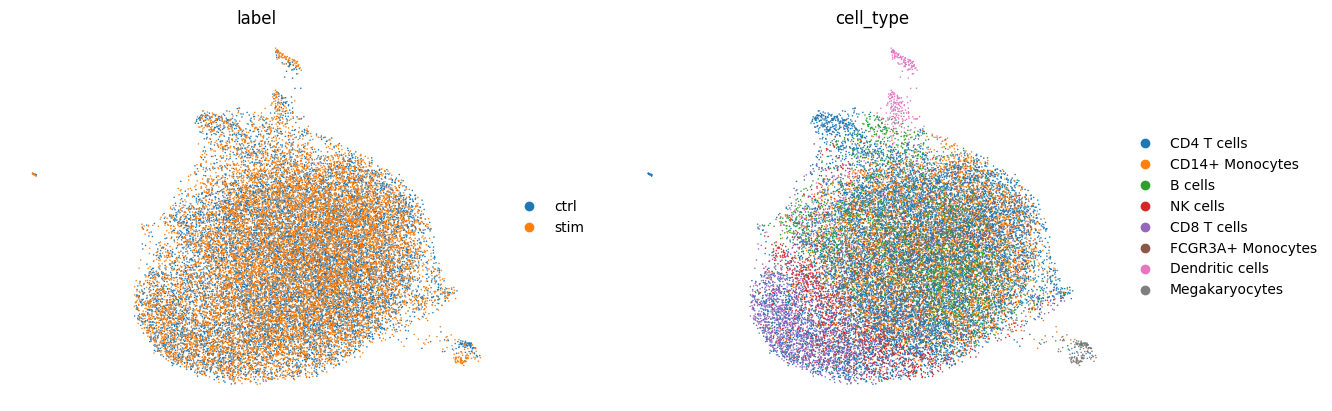

---UMAP for dis2p_Z_1---


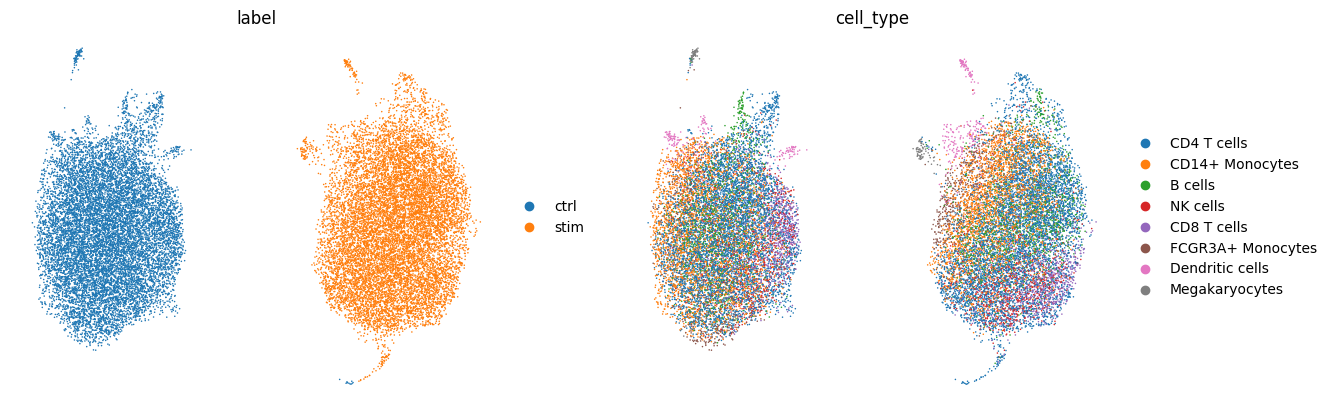

---UMAP for dis2p_Z_2---


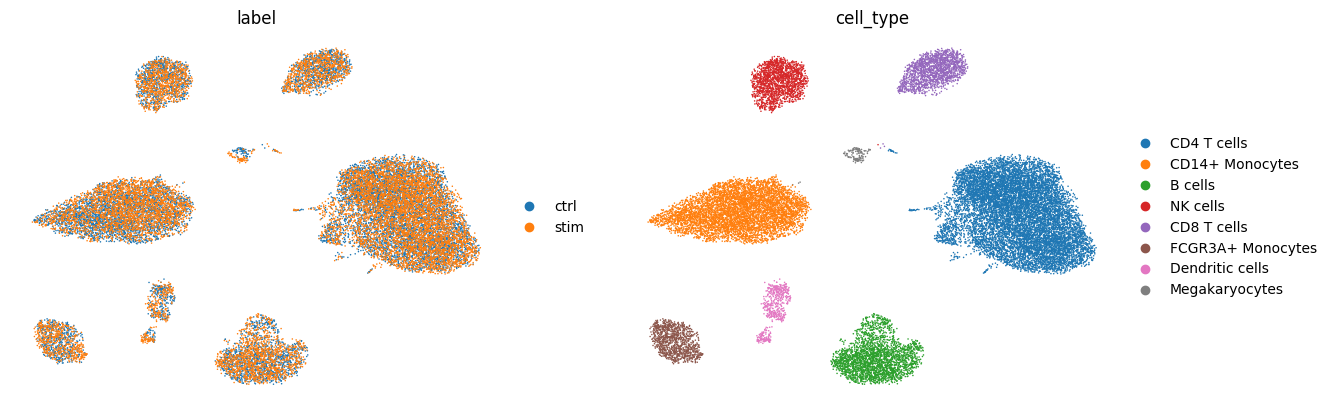

In [10]:
for i in range(len(cats) + 1):  # loop over all Z_i

    latent_name = f'dis2p_Z_{i}'

    print(f"---UMAP for {latent_name}---")

    sc.pp.neighbors(adata, use_rep=f"{latent_name}")
    sc.tl.umap(adata)

    sc.pl.umap(
        adata,
        color=cats,
        ncols=len(cats),
        frameon=False,
    )

## Train dis2p_cE version

In [11]:
module_name = 'dis2p_cE'
pre_path = f'models/{module_name}'
if not os.path.exists(pre_path):
    os.makedirs(pre_path)

# specify a name for your model
model_name =  f'{today},{module_name},{data_name},' + f'n_layers={n_layers},' + ','.join(k + '=' + str(v) for k, v in train_dict.items())

# load model (if trained before)
try:
    model = dvi.Dis2pVI_cE.load(f"{pre_path}/{model_name}", adata=adata)

# trains the model (if not trained before) and save it into: pre_path + model_name
except:
    dvi.Dis2pVI_cE.setup_anndata(
        adata,
        layer='counts',
        categorical_covariate_keys=cats,
        continuous_covariate_keys=[]
    )
    model = dvi.Dis2pVI_cE(adata, n_layers=n_layers)
    model.train(**train_dict)


INFO     No backup URL provided for missing file                                                                   
         models/dis2p_cE/2024-03-08,dis2p_cE,KangBlood,n_layers=1,max_epochs=80,batch_size=128,cf_weight=1,beta=1,c
         lf_weight=50,adv_clf_weight=10,adv_period=1,n_cf=1/model.pt                                               


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 57/80:  70%|▋| 56/80 [19:05<07:19, 18.30s/it, v_num=1, loss_validation=1.06e+3, x_0_validation=209, x_1_validation=213, x_2_validation=217, rec_Epoch 00057: reducing learning rate of group 0 to 6.0000e-04.
Epoch 71/80:  89%|▉| 71/80 [23:25<02:58, 19.79s/it, v_num=1, loss_validation=1.05e+3, x_0_validation=209, x_1_validation=213, x_2_validation=217, rec_
Monitored metric loss_validation did not improve in the last 45 records. Best score: 1050.495. Signaling Trainer to stop.


In [12]:
model.save(f"{pre_path}/{model_name}")

In [13]:
# load model
model = dvi.Dis2pVI_cE.load(f"{pre_path}/{model_name}", adata=adata)

# Z_0
adata.obsm[f'dis2p_cE_Z_0'] = model.get_latent_representation(nullify_cat_covs_indices=[s for s in range(len(cats))], nullify_shared=False)

for i in range(len(cats)):
    null_idx = [s for s in range(len(cats)) if s != i]
    # Z_i
    adata.obsm[f'dis2p_cE_Z_{i+1}'] = model.get_latent_representation(nullify_cat_covs_indices=null_idx, nullify_shared=True)
    # Z_{-i}
    adata.obsm[f'dis2p_cE_Z_not_{i+1}'] = model.get_latent_representation(nullify_cat_covs_indices=[i], nullify_shared=False)



INFO     File                                                                                                      
         models/dis2p_cE/2024-03-08,dis2p_cE,KangBlood,n_layers=1,max_epochs=80,batch_size=128,cf_weight=1,beta=1,c
         lf_weight=50,adv_clf_weight=10,adv_period=1,n_cf=1/model.pt already downloaded                            


In [14]:
adata.obsm[f'{module_name}'] = model.get_latent_representation(adata, nullify_cat_covs_indices=[0], nullify_shared=True)


---UMAP for dis2p_cE_Z_0---


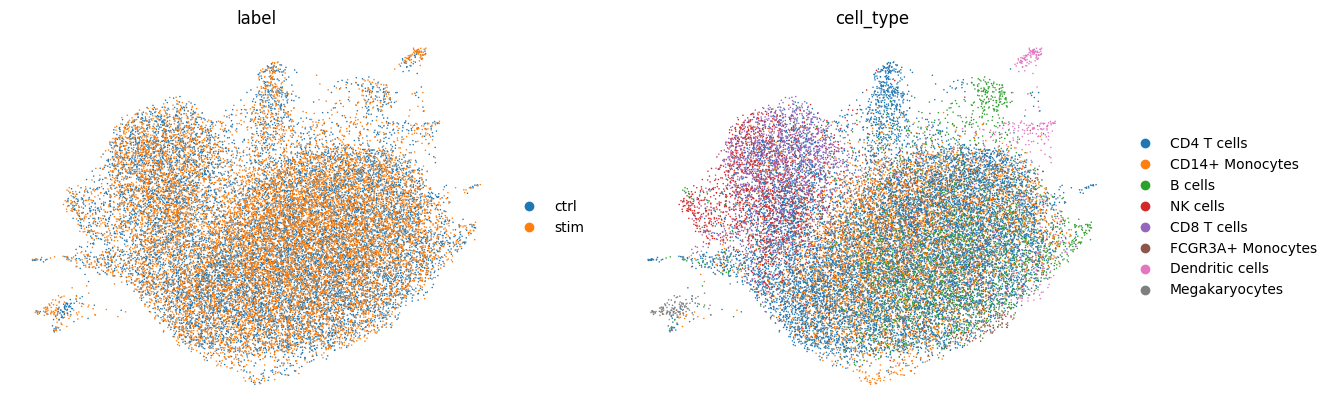

---UMAP for dis2p_cE_Z_1---


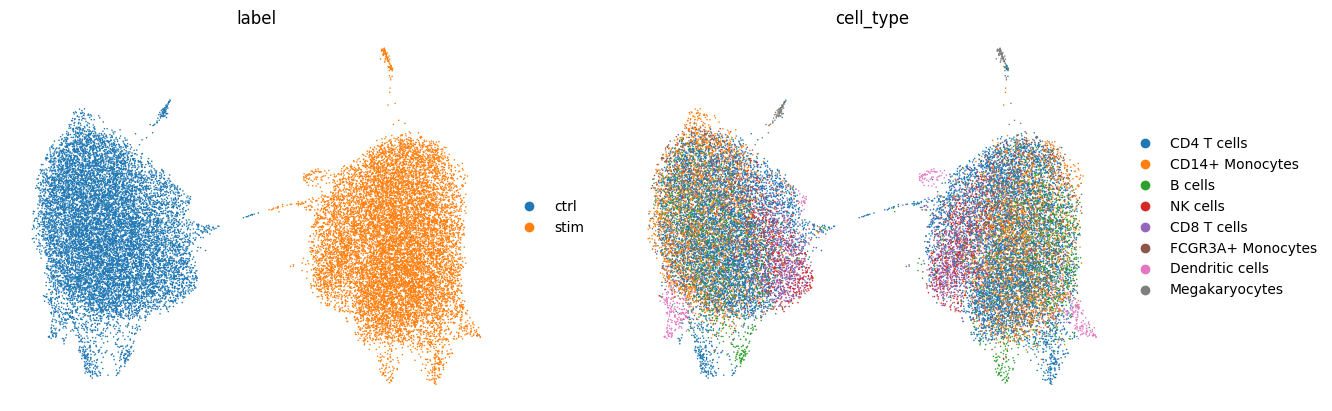

---UMAP for dis2p_cE_Z_2---


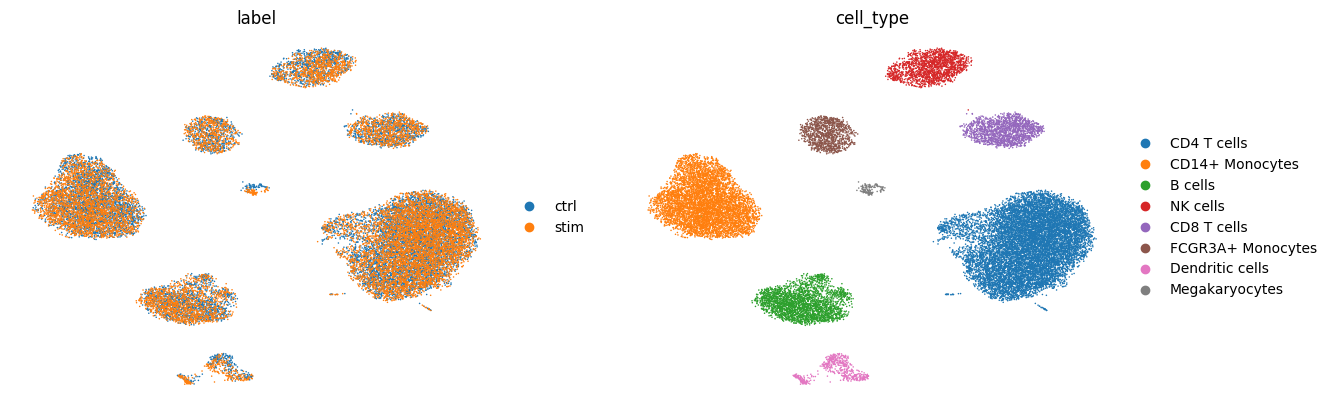

In [15]:
for i in range(len(cats) + 1):  # loop over all Z_i

    latent_name = f'dis2p_cE_Z_{i}'

    print(f"---UMAP for {latent_name}---")

    sc.pp.neighbors(adata, use_rep=f"{latent_name}")
    sc.tl.umap(adata)

    sc.pl.umap(
        adata,
        color=cats,
        ncols=len(cats),
        frameon=False,
    )

## We notice that the UMAPs of dis2p and dis2p_cE look almost identical, and dis2p_cE_Z0 looks better ie less noisy.

## Train Biolord

In [16]:
from data.biolord_dev.src import biolord

In [17]:

biolord.Biolord.setup_anndata(
    adata=adata,
    ordered_attributes_keys=[],
    categorical_attributes_keys=cats,
    layer="counts"
)

In [18]:
# params in these cells are taken from here: https://biolord.readthedocs.io/en/latest/tutorials/biolord_omics.html#instantiate-a-biolord-model
module_params = {
    "decoder_width": 512,
    "decoder_depth": 6,
    "attribute_nn_width": 256,
    "attribute_nn_depth": 2,
    "unknown_attribute_noise_param": 1e0,
    "seed": 42,
    "n_latent_attribute_ordered": 16,
    "n_latent_attribute_categorical": 16,
    "gene_likelihood": "poisson",
    "reconstruction_penalty": 1e1,
    "unknown_attribute_penalty": 1e0,
    "attribute_dropout_rate": 0.1
}
model = biolord.Biolord(
    adata=adata,
    n_latent=128,
    model_name="kang_biolord_new",
    module_params=module_params,
)

Global seed set to 42


In [19]:
trainer_params = {
    "n_epochs_warmup": 0,
    "latent_lr": 1e-4,
    "latent_wd": 1e-4,
    "decoder_lr": 1e-4,
    "decoder_wd": 1e-4,
    "attribute_nn_lr": 1e-2,
    "attribute_nn_wd": 4e-8,
    "step_size_lr": 45,
    "cosine_scheduler": True,
    "scheduler_final_lr": 1e-5,
}
model.train(
    max_epochs=400,
    batch_size=256,
    plan_kwargs=trainer_params,
    early_stopping=True,
    enable_checkpointing=False,
    early_stopping_patience=45,
    check_val_every_n_epoch=10,
    num_workers=1,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 73/400:  18%|▏| 73/400 [03:20<14:56,  2.74s/it, v_num=1, val_generative_mean_accuracy=0.952, val_generative_var_accuracy=0.648, val_biolord_metr
Monitored metric val_biolord_metric did not improve in the last 45 records. Best score: 0.807. Signaling Trainer to stop.


In [20]:
model.save(f'models/biolord_kang_{today}')

In [21]:
for i, c in enumerate(cats):
    nullify_attribute = [cat for cat in cats if cat != c]
    _, latent_adata = model.get_latent_representation_adata(adata=adata, nullify_attribute=nullify_attribute)
    adata.obsm[f"biolord_{i+1}"] = latent_adata.X
    
adata.obsm[f"biolord"] = adata.obsm[f"biolord_2"]

## Train scVI

In [22]:
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="label")
vae = scvi.model.SCVI(adata)
vae.train()
# vae.save("models/scVI")

# adata.obsm["scVI"] = vae.get_latent_representation()

#vae = scvi.model.SCVI.load("models/scVI", adata=adata)




GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 324/324: 100%|████████████████████████████████████████████| 324/324 [22:31<00:00,  4.06s/it, v_num=1, train_loss_step=202, train_loss_epoch=205]

`Trainer.fit` stopped: `max_epochs=324` reached.


Epoch 324/324: 100%|████████████████████████████████████████████| 324/324 [22:31<00:00,  4.17s/it, v_num=1, train_loss_step=202, train_loss_epoch=205]


ValueError: models/scVI already exists. Please provide another directory for saving.

In [23]:
vae.save("models/scVI"+today+data_name)

adata.obsm["scVI"] = vae.get_latent_representation()

## Train scanvi

In [26]:
lvae = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=adata,
    labels_key="cell_type",
    unlabeled_category="Unknown",
)
lvae.train(max_epochs=20, n_samples_per_label=100)
lvae.save("models/scANVI+today+data_name")
adata.obsm["scANVI"] = lvae.get_latent_representation()

#lvae_new = scvi.model.SCANVI.load("models/scANVI_new", adata=adata)


INFO     Training for 20 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 20/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:26<00:00,  7.23s/it, v_num=1, train_loss_step=249, train_loss_epoch=253]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:26<00:00,  7.33s/it, v_num=1, train_loss_step=249, train_loss_epoch=253]


## Let's store PCA values

In [27]:
adata.obsm['PCA'] = adata.obsm['X_pca']


## Train Harmony

In [28]:
from harmony import harmonize

adata.obsm["Harmony"] = harmonize(adata.obsm["X_pca"], adata.obs, batch_key="label")

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
Reach convergence after 6 iteration(s).


## Let's benchmark using scIB

scib benchmark metrics for (batch_key=label, label_key=cell_type)


Metrics:   0%|                                                                                                                                 | 0/10 [00:00<?, ?it/s, Bio conservation: isolated_labels]2024-03-08 15:43:47.082126: W external/xla/xla/service/gpu/nvptx_compiler.cc:698] The NVIDIA driver's CUDA version is 11.2 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.

Metrics:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 8/10 [01:08<00:27, 13.59s/it, Batch correction: pcr_comparison]2024-03-08 15:45:03.778425: E external/xla/xla/stream_executor/gpu/gpu_graph.cc:52] Failed to trim Gpu device graph memory: Failed to trim device graph memory: CUDA_ERROR_SHARED_OBJECT_INIT_FAILE

<Figure size 6400x4800 with 0 Axes>

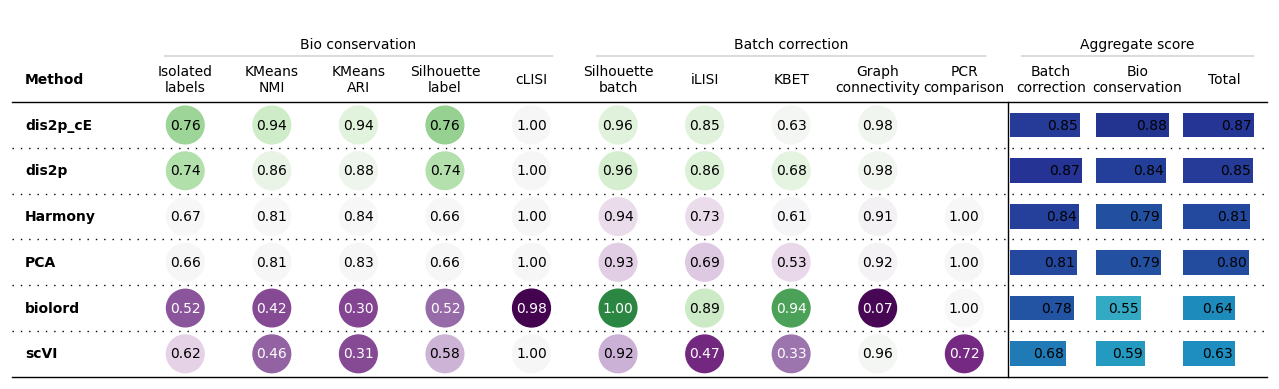

In [29]:
batch_key = cats[0]
label_key = cats[1]

print(f'scib benchmark metrics for (batch_key={batch_key}, label_key={label_key})')

bm = Benchmarker(
    adata,
    batch_key=batch_key,
    label_key=label_key,
    #embedding_obsm_keys=['PCA', 'scVI', 'scANVI', 'Harmony', 'LIGER', 'biolord', 'dis2p'],
    embedding_obsm_keys=['PCA', 'scVI', 'biolord', 'dis2p', 'dis2p_cE', 'Harmony'],
    n_jobs=-1,
)
bm.benchmark()

plt.figure(dpi=1000)
plt.savefig("metrics/scib.png")

bm.plot_results_table(min_max_scale=False)